## Image Analysis

In [0]:
from PIL import Image
from IPython.display import display
import os
import pandas as pd
import numpy as np

In [0]:
pwd

'/content'

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/My\ Drive/pytorch/CAT_DOG/CATS_DOGS.zip /content

In [0]:
!unzip CATS_DOGS.zip

Archive:  CATS_DOGS.zip
replace CATS_DOGS/test/CAT/10000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
## Number of train Image
!ls -l CATS_DOGS/train/CAT/ | wc -l

9372


In [0]:
## Number of test image
!ls -l CATS_DOGS/test/DOG/ | wc -l

3126


In [0]:
pwd

'/content'

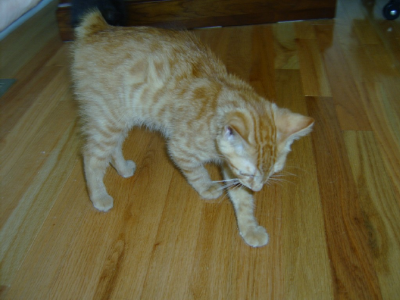

In [0]:
from PIL import Image
from IPython.display import display

#Verify file path
with Image.open("./CATS_DOGS/train/CAT/8183.jpg") as img:
  display(img)

In [0]:
cwd = os.getcwd()

path = os.path.join(cwd,"CATS_DOGS")
img_name = []

for folder, subfolder, filename in os.walk(path):
  for img in filename:
    img_name.append(folder+"/"+img)

In [0]:
img_size = []
reject_size = []

for i in img_name:
  try:
    with Image.open(i) as img:
      img_size.append(img.size)
  
  except:
    reject_size.append(i)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

In [0]:
print(f"Number of Valid Images: {len(img_size)}")
print(f"Number of corrupted: {len(reject_size)}")

Number of Valid Images: 24994
Number of corrupted: 0


In [0]:
df = pd.DataFrame(img_size)
df.describe()

,0,1
count,24994.000000,24994.000000
mean,404.493518,361.037129
std,108.941802,96.936811
min,42.000000,33.000000
25%,323.000000,302.000000
50%,448.000000,375.000000
75%,500.000000,421.000000
max,500.000000,500.000000


# Conv - VGG16

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models
from torchvision.utils import make_grid


import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [0]:
## Transform for train dataset
train_transform = transforms.Compose([
                                      transforms.RandomRotation(10),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Transform for test dataset
test_transform = transforms.Compose([
                                     transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [0]:
#Current path
cwd = os.getcwd()
path = os.path.join(cwd, "CATS_DOGS")

#Allocating train and test dataset from ImageFolder
train_data = datasets.ImageFolder(os.path.join(path, "train"), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(path,"test"), transform=test_transform)

torch.manual_seed(42)

## Loading train and test using DataLoader with batch size 10.
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

class_name = train_data.classes

In [0]:
print(class_name)

['CAT', 'DOG']


In [0]:
print(f"Length of train: {len(train_data)}")
print(f"Length of test: {len(test_data)}")

Length of train: 18743
Length of test: 6251


In [0]:
image, label = next(iter(train_loader))

In [0]:
print(f"Size of each batch: {image.shape}")
print(f"Labels in first batch: {label}")

Size of each batch: torch.Size([10, 3, 224, 224])
Labels in first batch: tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 0])


Labels: [   1    0    1    0    0    1    0    1    0    0]


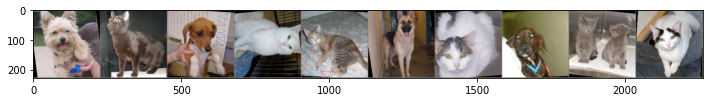

In [0]:
## Visualize the images and labels in the first batch.
# Formatter
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

im = make_grid(image, nrow=10)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                     std=[1/0.229, 1/0.224, 1/0.225])
im_inv = inv_normalize(im)
print(f"Labels: {label[:10].numpy()}")

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [0]:
#VGG Class

In [0]:
class ConvVGGNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv11 = nn.Conv2d(3,64,3,1,padding=1)
    self.conv12 = nn.Conv2d(64,64,3,1,padding=1)

    self.conv21 = nn.Conv2d(64,128,3,1, padding=1)
    self.conv22 = nn.Conv2d(128,128,3,1,padding=1)

    self.conv31 = nn.Conv2d(128,256,3,1,padding=1)
    self.conv32 = nn.Conv2d(256,256,3,1,padding=1)
    self.conv33 = nn.Conv2d(256,256,3,1,padding=1)

    self.conv41 = nn.Conv2d(256,512,3,1,padding=1)
    self.conv42 = nn.Conv2d(512,512,3,1,padding=1)
    self.conv43 = nn.Conv2d(512,512,3,1,padding=1)

    self.conv51 = nn.Conv2d(512,512,3,1,padding=1)
    self.conv52 = nn.Conv2d(512,512,3,1,padding=1)
    self.conv53 = nn.Conv2d(512,512,3,1,padding=1)

    self.fc1 = nn.Linear(7*7*512, 4096)
    self.fc2 = nn.Linear(4096,4096)
    self.fc3 = nn.Linear(4096, 2)

    #self.fcs = nn.Sequential(
    #    nn.Linear(7*7*512, 4096),
    #    nn.ReLU(),
    #    nn.Dropout(p=0.5),
    #    nn.Linear(4096,4096),
    #    nn.ReLU(),
    #    nn.Dropout(p=0.5),
    #    nn.Linear(4096, 2)
    #)


  def forward(self, X):
    X = F.relu(self.conv11(X))
    X = F.relu(self.conv12(X))
    X = F.max_pool2d(X,2,2)

    X = F.relu(self.conv21(X))
    X = F.relu(self.conv22(X))
    X = F.max_pool2d(X,2,2)

    X = F.relu(self.conv31(X))
    X = F.relu(self.conv32(X))
    X = F.relu(self.conv33(X))
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv41(X))
    X = F.relu(self.conv42(X))
    X = F.relu(self.conv43(X))
    X = F.max_pool2d(X,2,2)

    X = F.relu(self.conv51(X))
    X = F.relu(self.conv52(X))
    X = F.relu(self.conv53(X))
    X = F.max_pool2d(X,2,2)

    X = X.view(-1, 7*7*512)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)  
    return F.log_softmax(X, dim=1)

    

In [0]:
torch.manual_seed(101)
VGGModel = ConvVGGNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGGModel.parameters(), lr=0.001)

In [0]:
VGGModel

ConvVGGNet(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv33): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv43): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv51): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv52): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv53): Conv2d(512, 512, kerne

In [0]:
for params in VGGModel.parameters():
  print(params.numel())

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
8192
2


In [0]:
import time
start_time = time.time()

epoch = 3
train_loss = []
test_loss = []
train_correct = []
test_correct = []


for i in range(epoch):
  batch_train_correct = 0
  batch_test_correct = 0
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1

    #Model train
    y_pred = VGGModel(X_train)
    
    #Predict the model
    prediction = torch.max(y_pred, 1)[1]
    batch_correct = (prediction==y_train).sum()
    batch_train_correct += batch_correct
    loss = criterion(y_pred, y_train)
    
    #Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print the training outputs
    if b%1 == 0:
      acc = int(batch_train_correct)/int(b*10)
      #print(batch_train_correct)
      print(f"Epoch: {i}, batch = {b}, Loss: {loss.item()}, Accuracy={acc}")

  #Append the training status and metrics in list.
  train_loss.append(loss)
  train_correct.append(batch_train_correct)

  #With applying no baises and weights
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):

      #Apply model in test data.
      y_val = VGGModel(X_test)

      #Prediction on test datasets
      prediction = torch.max(y_val, 1)[1]
      batch_correct = (prediction==y_test).sum()
      batch_test_correct += batch_correct
    
    #Find losses and batch_correct and append into corresponding lists.
    loss = criterion(y_val, y_test)
    test_loss.append(loss)
    test_correct.append(batch_test_correct)

end_time = time.time() - start_time

print("Total time required: {end_time}")

Epoch: 0, batch = 1, Loss: 0.6893997192382812, Accuracy=0.6
Epoch: 0, batch = 2, Loss: 0.6933313012123108, Accuracy=0.55
Epoch: 0, batch = 3, Loss: 0.6931402683258057, Accuracy=0.5333333333333333
Epoch: 0, batch = 4, Loss: 0.6928426027297974, Accuracy=0.55


KeyboardInterrupt: ignored

# Another Method

In [0]:
VGG = [64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M"]

In [0]:
class VGGNET(nn.Module):
  def __init__(self,in_channel=3,num_classes=2):
    super(VGGNET, self).__init__()
    self.in_channel=in_channel
    self.num_classes=num_classes
    self.conv_layers = self.create_conv_layers(VGG)

    self.fcs = self.full_connected()
  
  def full_connected(self):
    fc_layer = nn.Sequential(nn.Linear(512*7*7,4096),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(4096,4096),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(4096,self.num_classes))
    return fc_layer
  
  def create_conv_layers(self, arch):
    layers=[]
    in_channels=self.in_channel
    for i in arch:
      if type(i)==int:
        layers+=[nn.Conv2d(in_channels, i, 3,1,padding=1),
                 nn.BatchNorm2d(i),
                 nn.ReLU()]
        in_channels = i
      elif i=="M":
        layers+=[nn.MaxPool2d(2,2)]
    return nn.Sequential(*layers)

  def forward(self, X):
    X = self.conv_layers(X)
    X = X.view(-1,512*7*7)
    X = self.fcs(X)
    return F.log_softmax(X, dim=1)
  

In [0]:
VGGNET()

VGGNET(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [0]:
torch.manual_seed(101)
model = VGGNET()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
for params in model.parameters():
  print(params.numel())

1728
64
64
64
36864
64
64
64
73728
128
128
128
147456
128
128
128
294912
256
256
256
589824
256
256
256
589824
256
256
256
1179648
512
512
512
2359296
512
512
512
2359296
512
512
512
2359296
512
512
512
2359296
512
512
512
2359296
512
512
512
102760448
4096
16777216
4096
8192
2


In [0]:
import time
start_time = time.time()

epoch = 3
train_loss = []
test_loss = []
train_correct = []
test_correct = []

for i in range(epoch):
  batch_train_correct = 0
  batch_test_correct = 0
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1

    #Model train
    y_pred = model(X_train)
    
    #Predict the model
    prediction = torch.max(y_pred, 1)[1]
    batch_correct = (prediction==y_train).sum()
    batch_train_correct += batch_correct
    loss = criterion(y_pred, y_train)
    
    #Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print the training outputs
    if b%1 == 0:
      acc = int(batch_train_correct)/int(b*10)
      #print(batch_train_correct)
      print(f"Epoch: {i}, batch = {b}, Loss: {loss.item()}, Accuracy={acc}")

  #Append the training status and metrics in list.
  train_loss.append(loss)
  train_correct.append(batch_train_correct)

  #With applying no baises and weights
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):

      #Apply model in test data.
      y_val = model(X_test)

      #Prediction on test datasets
      prediction = torch.max(y_val, 1)[1]
      batch_correct = (prediction==y_test).sum()
      batch_test_correct += batch_correct
    
    #Find losses and batch_correct and append into corresponding lists.
    loss = criterion(y_val, y_test)
    test_loss.append(loss)
    test_correct.append(batch_test_correct)

end_time = time.time() - start_time

print("Total time required: {end_time}")

Epoch: 0, batch = 1, Loss: 0.7804552316665649, Accuracy=0.3
Epoch: 0, batch = 2, Loss: 27.059900283813477, Accuracy=0.45


KeyboardInterrupt: ignored

In [0]:
model = VGGNET()

X_train, Y_train = next(iter(train_loader))

y_pred = model(X_train)

In [0]:
prediction = torch.max(y_pred, 1)[1]

In [0]:
prediction

tensor([0, 0, 1, 0, 0, 1, 0, 1, 1, 0])

In [0]:
batch_correct = (prediction==y_train).sum()

In [0]:
batch_correct

tensor(3)